## Table of Contents
1. [Introduction](#introduction)
2. [Methods](#methods)

   2.1. [Preprocessing](#preprocessing)
      * [Terminology & examples](#some-terminology)

   2.2. [Extracting shared constructions](#extracting-shared-constructions)

   2.3. [Filtering shared constructions](#linking-shared-constructions)

   2.4. [Linking shared constructions](#linking-shared-constructions)
      * [Example](#example)

3. [Analysis & results](#results)

   3.1. [Presence of Shared Constructions and their Patterns of Use over Dialogue Rounds](#presence_alignment)
   
   3.2. [Individual Speaker Names versus Interactive Shared Constructions](#individual_vs_shared) 
        
   3.3. [Naming Convergence Across Speakers is Linked to Shared Constructions](#naming_convergence)


### Note: please note that, in this notebook, we use the term "construction" to refer to a sequence of lemmas that is repeated across multiple dialogues. This term is used interchangeably with "expression". 

### Import libraries & methods <a class="anchor" id="importing_libraries"></a>

In [1]:
# code to import python libraries and set up the notebook
import seaborn as sns
import pandas as pd
import numpy as np
import colorcet as cc

from utils.read_labeled_and_pos_target_data import assert_match_betwee_shared_exp_and_actual_utterances, prepare_dialogue_shared_expressions_and_turns_info, extract_all_shared_exp_info, all_func_words
from utils.link_target_expressions import link_shared_expressions_final_algo, link_identical_shared_expressions_based_on_pair, link_shared_expressions_fribble_based
from utils.data_containers_forced_alignment import Turn, Gesture, Utterance
from utils.read_stop_function_words import read_stop_function_words

import spacy
from utils.similarity_measures import get_naming_task
# use genism to load the word2vec model

pd.set_option("display.precision", 2)
palette = sns.color_palette(cc.glasbey_hv, n_colors=25)
sns.set_theme(style="whitegrid", palette=palette) 

/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/eghaleb/anacon

In [2]:
from utils.read_labeled_and_pos_target_data_pseudo import prepare_dialogue_shared_expressions_and_turns_info_pseudo 

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
space_lg_nlp = spacy.load("nl_core_news_lg")
naming_task = get_naming_task(nlp=space_lg_nlp)

In [5]:
# code to set up the paths
dialign_output = '../dialign/output_targets_riws_lemma_lg/'
turn_info_path = '../dialign/targets_riws_lemma_lg/'
fribbles_path = "../data/CABB/objects_fribbles/{}.jpg"
videos_path = '~/data/{}_synced_overview.mp4'
pos_func_words = ['DET', 'PRON', 'ADP', 'CCONJ', 'SCONJ', 'AUX', 'PART', 'PUNCT', 'SYM', 'X', 'INTJ', 'NUM', 'SPACE']
frequent_words, function_words = read_stop_function_words()

In [6]:
# code to set up the paths
pseudo_dialign_output = '../dialign/output_targets_riws_lemma_pseudo'
pseudo_turn_info_path = '../dialign/targets_riws_lemma_pseudo/'

# 1. Introduction <a class="anchor" id="introduction"></a>
<!-- # ~/anaconda3/envs/lex/bin/pip install statannotations
# /Users/esamghaleb/anaconda3/bin/pip install spacy -->
This notebook includes the data processing methods used to operationalise linguistic alignment and the results reported in the paper. Linguistic alignment is detected based on a lemmatized speech at the level of the lemmas' form. In a Pairs, single lemmas or sequences of lemmas used at least once by **both** participants are defined as shared expressions and considered instances of lexical linguistic.

# 2. Methods<a class="anchor" id="methods"></a>

# 2.1. Pre-processing Dialogues and Extracting Shared Constructions <a class="anchor" id="preprocessing"></a>
The details of the pre-processing steps are described README.md file in the main directory of the project.

## Some terminology <a class="anchor" id="some-terminology"></a>

* **Initiation turn/round:** The turn or round where a shared expression was first introduced by one of the participants.
* **Establishing turn/round:** The turn or round where the shared expression was first repeated by the other participant, i.e., it becomes shared.
* **Speaker role:** **D** & **M** indicate whether the shared expression was used by the director or the matcher.
* **Initiator role:** The participant who introduced the shared expression, i.e., the director or the matcher.
* **Establisher role:** The participant who established the shared expression, i.e., the director or the matcher.
* **Turns** and **rounds:** the turns and rounds numbers where shared expressions are used. 
* **Length:** the number of lemmas in the shared expression.
* **Target fribble:** the fribble for which the shared expression was used.
* **Frequency:** the number of times the shared expression was used.

In [7]:
pos_func_words = ['DET', 'PRON', 'ADP', 'CCONJ', 'SCONJ', 'AUX', 'PART', 'PUNCT', 'SYM', 'X', 'INTJ', 'SPACE', 'NUM']
stop_words, function_words = read_stop_function_words()

# 2.2. Extracting shared constructions <a class="anchor" id = "extracting-shared-constructions"></a>

The steps to extract shared constructions are explained in the README.md file in the main directory of the project. In this notebook, we load the extracted shared constructions and analyse them. We load the shared constructions for real and control dialogues and compare them.


### Load shared constructions of real dialogues

In [8]:
# code to read the shared expressions and turns info of real pairs
real_shared_constructions_info, real_turns_info = prepare_dialogue_shared_expressions_and_turns_info(dialign_output, turn_info_path)
real_exp_info = extract_all_shared_exp_info(real_shared_constructions_info, real_turns_info)

### Load shared constructions of Pseudo Pairs (control dialogues)

In [9]:
pseudo_shared_constructions_info, pseudo_turns_info = prepare_dialogue_shared_expressions_and_turns_info_pseudo(pseudo_dialign_output, pseudo_turn_info_path)
pseudo_exp_info = extract_all_shared_exp_info(pseudo_shared_constructions_info, pseudo_turns_info)

# 2.3. Filtering shared constructions <a class="anchor" id="filtering-shared-constructions"></a>
We filter out shared constructions consisting only of function words or very common words. To identify function words, we use POS tagging and remove phrases that only contain them. We also consider highly frequent words based on word frequencies in the SUBTLEX-NL corpus. We focus on shared constructions used by one fribble in the entire dialogue and set aside those used for multiple fribbles for future analysis. This gives us a set of unique shared constructions per fribble, representing the contentful lemmas used exclusively by both participants for each fribble.

More details on the filtering process are provided in the README.md file in the main directory of the project.

In [10]:
def clean_exp_info(exp_info, function_words, stop_words):
   exp_with_only_func_words = np.logical_not([all_func_words(pos_seq, pos_func_words) for idx, pos_seq in enumerate(exp_info['pos_seq'].to_list())])
   exp_info = exp_info[exp_with_only_func_words]
   exp_with_only_func_words = np.logical_not([all_func_words(exp, function_words) for idx, exp in enumerate(exp_info['exp'].to_list())])
   exp_info = exp_info[exp_with_only_func_words]
   exp_with_only_stop_words = np.logical_not([all_func_words(exp, stop_words) for idx, exp in enumerate(exp_info['exp'].to_list())])
   exp_info = exp_info[exp_with_only_stop_words]
   return exp_info
def link_exp_info(exp_info, turns_info, shared_constructions_info):
   exp_info['shared expressions'] = exp_info['exp'].apply(lambda x: [x])
   exp_info = link_identical_shared_expressions_based_on_pair(turns_info, exp_info)
   # check if there are nan values in exp_info
   assert not exp_info.isnull().values.any()
   exp_info = exp_info[exp_info['#fribbles'] == 1]
   # Here, we assert that all detected shared expressions are in the original lemmatized utterances, with matching turn numbers
   assert_match_betwee_shared_exp_and_actual_utterances(turns_info, shared_constructions_info)
   return exp_info

real_exp_info = clean_exp_info(real_exp_info, function_words, stop_words)
pseudo_exp_info = clean_exp_info(pseudo_exp_info, function_words, stop_words)

real_exp_info = link_exp_info(real_exp_info, real_turns_info, real_shared_constructions_info)
pseudo_exp_info = link_exp_info(pseudo_exp_info, pseudo_turns_info, pseudo_shared_constructions_info)


## 2.4. Linking shared constructions with a common lexical core <a class="anchor" id="linking-shared-constructions"></a>

The methods described above may result in sets of unique shared expressions per fribble that contain highly overlapping expressions. For example, for fribble 14, pair 10 uses the shared expressions "de bal bovenop" and "de bal," which overlap significantly. To identify such overlaps, we use regular expressions and link the expressions based on the overlap of content lemmas. We do not link the expressions if the overlapping sequence contains only function words.

This process produces sets of shared expression types that reflect a common underlying conceptualization or lexical core, which we consider instances of lexical alignment. To simplify the labeling of these types, we assign a common lexical core as the label, which is the shortest common sequence for the set. For instance, Pair 5 has three sets of shared expressions, each labeled with a common lexical core, such as "paddestoel," which includes three shared expressions: "een paddestoel," "een paddestoel op zijn hoofd," and "paddestoel op zijn hoofd."

To illustrate the linking process of shared expressions, consider the example below for Pair 5 and Fribble 1.
<!-- > **PLOT** include plot for Pair 5 example after linking; for each occurance include which speaker (A,B) utters it. -->

In [11]:
from utils.link_target_expressions import final_linking_algo_individually
real_fribble_specific_exp_info = final_linking_algo_individually(real_turns_info, real_exp_info, real_shared_constructions_info, function_words, pos_func_words, pseudo_pairs=False, frequent_words=frequent_words)
pseudo_fribble_specific_exp_info = final_linking_algo_individually(pseudo_turns_info, pseudo_exp_info, pseudo_shared_constructions_info, function_words, pos_func_words, pseudo_pairs=True, frequent_words=frequent_words)

## Example <a class="anchor" id="example"></a>
To illustrate the linking process of shared expressions, consider the example below for Pair 5 and Fribble 1.

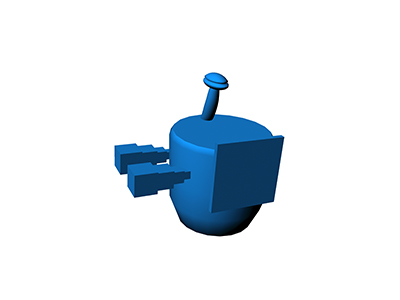

,shared construction types,shared constructions,freq,speakers,speaker role,initiator role,establisher role,rounds
0,deze hebben een paddestoel op zijn hoofd,[deze hebben een paddestoel op zijn hoofd],2,"[B, A]","[D, D]",[D],[D],"[3, 4]"
1,paddestoel op zijn hoofd,[paddestoel op zijn hoofd],4,"[A, B, A, A]","[D, D, D, D]",[D],[D],"[2, 3, 4, 6]"
2,twee vierkant schroef,[twee vierkant schroef],3,"[B, A, B]","[D, D, M]",[D],[D],"[1, 4, 6]"
3,een scherm,[een scherm],2,"[B, A]","[D, D]",[D],[D],"[3, 4]"
4,paddestoel,[paddestoel],5,"[A, B, A, B, A]","[D, D, D, D, D]",[D],[D],"[2, 3, 4, 5, 6]"


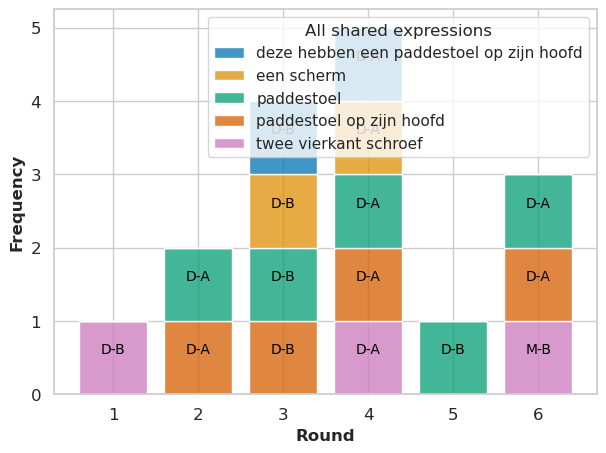

#################################### shared expressions after linking ####################################


,shared construction types,shared constructions,freq,speakers,speaker role,initiator role,establisher role,rounds
0,paddestoel,"[paddestoel op zijn hoofd, deze hebben een paddestoel op zijn hoofd, paddestoel]",5,"[A, B, A, B, A]","[D, D, D, D, D]",[D],[D],"[2, 3, 4, 5, 6]"
1,twee vierkant schroef,[twee vierkant schroef],3,"[B, A, B]","[D, D, M]",[D],[D],"[1, 4, 6]"
2,een scherm,[een scherm],2,"[B, A]","[D, D]",[D],[D],"[3, 4]"


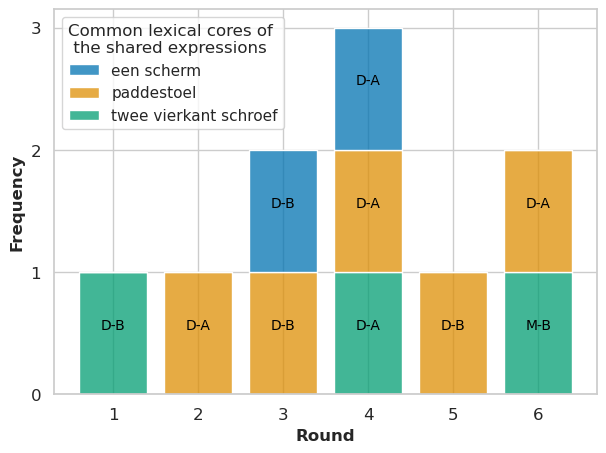

In [12]:
num_fribbles = 1
target_fribble = '01'
target_pair = 'pair05'
pair = target_pair
real_exp_info['number of rounds'] = real_exp_info.apply(lambda x: len(np.unique(x['rounds'])), axis=1)
real_exp_info['label'] = real_exp_info['exp']
linked_expressions = link_shared_expressions_fribble_based(real_turns_info, real_exp_info, function_words, pos_func_words, num_fribbles=num_fribbles, target_fribble=target_fribble, target_pair=target_pair, fribbles_path=fribbles_path, videos_path=videos_path, save_clips=False)

In [14]:
pseudo_fribble_specific_exp_info['Pairs'] = 'Pseudo'
real_fribble_specific_exp_info['Pairs'] = 'Real'
# combine the pseudo and real data
fribble_specific_exp_info = pd.concat([real_fribble_specific_exp_info, pseudo_fribble_specific_exp_info])
# combine turns_info and pseudo_turns_info dictionaries
turns_info = {**real_turns_info, **pseudo_turns_info}

# Now, we have two main Dataframes:
* fribble_specific_exp_info: where each row corresponds to a shared construction type. The other columns show the types of features (such as rounds, turns, etc). It contains the construction types for real and pseudo pairs.

* real_exp_info: Each row contains a shared construction for real pairs
* pseudo_exp_info: Each row contains a shared construction for pseudo pairs

Check the example below for fribble_specific_exp_info where shared expressions --> shared constructions , where label is the common lexical item for the shared constructions

In [17]:
fribble_specific_exp_info.head() 

,label,length,fribbles,target_fribbles,#fribbles,fribbles entropy,speakers,freq,free. freq,priming,...,establishment_ts,shared expressions,target_fribble,exp,#shared expressions,expressions_set,number of rounds,content_words_exp,int_pair,Pairs
0,groot,1,"[1, 1, 1, 1, 1, 1, 1]",[1],1,0.0,"[B, A, A, B, A, B, A]",7,1,1,...,1408.94,"[groot, en de groot worden, de groot worden]",1,groot,3,worden en de groot,6,groot,17018,Real
1,vlak aan de voorkant,4,"[1, 1]",[1],1,0.0,"[A, B]",2,2,1,...,1590.51,[vlak aan de voorkant],1,vlak aan de voorkant,1,de aan vlak voorkant,2,voorkant vlak,17018,Real
2,vierkant plaat,2,"[1, 1, 1]",[1],1,0.0,"[B, B, A]",3,3,2,...,3157.07,[vierkant plaat],1,vierkant plaat,1,plaat vierkant,3,plaat vierkant,17018,Real
3,de telescoop,2,"[2, 2, 2, 2, 2]",[2],1,0.0,"[B, A, B, A, B]",5,1,1,...,1734.01,"[en de telescoop, driehoek bovenop en de telescoop, de telescoop]",2,de telescoop,3,de telescoop driehoek en bovenop,5,telescoop driehoek bovenop,17018,Real
4,driehoek bovenop,2,"[2, 2, 2]",[2],1,0.0,"[A, B, A]",3,1,1,...,2205.18,"[driehoek bovenop, driehoek bovenop en de telescoop]",2,driehoek bovenop,2,de telescoop driehoek en bovenop,3,telescoop driehoek bovenop,17018,Real


# Prepare the data of the Naming Task

In [15]:
from utils.gather_naming_similarities_pseudo import get_pre_post_pseudo_names
from utils.gather_naming_similarities import get_pre_post_names, calculate_features_for_each_fribble_per_pair, measure_distances_between_names
from utils.calculate_shared_constructions_features import calculate_main_simple_feats

def get_names_for_pseudo_pairs(fribble_specific_exp_info, naming_task):
   pre_post_pseudo_names = get_pre_post_pseudo_names(naming_task, fribble_specific_exp_info)
   return pre_post_pseudo_names

pre_post_real_names = get_pre_post_names(naming_task, fribble_specific_exp_info[fribble_specific_exp_info['Pairs'] == 'Real'])
pre_post_real_names = measure_distances_between_names(pre_post_real_names, fribble_specific_exp_info[fribble_specific_exp_info['Pairs'] == 'Real'])
pre_post_real_names = calculate_main_simple_feats(pre_post_real_names, fribble_specific_exp_info[fribble_specific_exp_info['Pairs'] == 'Real'])
pre_post_real_names = calculate_features_for_each_fribble_per_pair(pre_post_real_names, fribble_specific_exp_info[fribble_specific_exp_info['Pairs'] == 'Real'])

pre_post_names_pseudo = get_names_for_pseudo_pairs(fribble_specific_exp_info[fribble_specific_exp_info['Pairs'] == 'Pseudo'], naming_task)
pre_post_names_pseudo = measure_distances_between_names(pre_post_names_pseudo, fribble_specific_exp_info[fribble_specific_exp_info['Pairs'] == 'Pseudo'])
pre_post_names_pseudo = calculate_main_simple_feats(pre_post_names_pseudo, fribble_specific_exp_info[fribble_specific_exp_info['Pairs'] == 'Pseudo'])
pre_post_names_pseudo = calculate_features_for_each_fribble_per_pair(pre_post_names_pseudo, fribble_specific_exp_info[fribble_specific_exp_info['Pairs'] == 'Pseudo'])

pre_post_names_pseudo['Pairs'] = 'Pseudo'
pre_post_real_names['Pairs'] = 'Real'
pre_post_names = pd.concat([pre_post_names_pseudo, pre_post_real_names])
pre_post_names = pre_post_names.rename(columns={'number of core labels': 'Number of shared expression types'})
pre_post_names['Number of shared expression types'] = pre_post_names['Number of shared expression types'].astype(int)

In [21]:
pseudo_fribble_specific_exp_info['Pairs'] = 'Pseudo'
real_fribble_specific_exp_info['Pairs'] = 'Real'
# combine the pseudo and real data
fribble_specific_exp_info = pd.concat([real_fribble_specific_exp_info, pseudo_fribble_specific_exp_info])
# combine turns_info and pseudo_turns_info dictionaries
turns_info = {**real_turns_info, **pseudo_turns_info}
real_fribble_specific_exp_info['target_fribble'] = real_fribble_specific_exp_info['target_fribbles'].apply(lambda x: x[0])
pseudo_fribble_specific_exp_info['target_fribble'] = pseudo_fribble_specific_exp_info['target_fribbles'].apply(lambda x: x[0]) 
len_exp_per_fribble_and_pair_real = real_fribble_specific_exp_info['length'].to_numpy()
len_exp_per_fribble_and_pair_psuedo = pseudo_fribble_specific_exp_info['length'].to_numpy()

from utils.similarity_measures import prepare_per_speaker_for_all_data
real_exp_info['int_pair'] = real_exp_info['pair'].apply(lambda x: int(x.replace('pair', '')))
real_exp_info['Pairs'] = 'Real'

pseudo_exp_info['pair'].apply(lambda x: x.replace('pair', '').replace('_and_', '')).astype(int)
pseudo_exp_info['speaker_A_pair'] = pseudo_exp_info['pair'].apply(lambda x: int(x.replace('pair', '').split('_')[0]))
pseudo_exp_info['speaker_B_pair'] = pseudo_exp_info['pair'].apply(lambda x: int(x.replace('pair', '').split('_')[-1]))
# put the number next to each other
pseudo_exp_info['int_pair'] = pseudo_exp_info['speaker_A_pair'].astype(str) + pseudo_exp_info['speaker_B_pair'].astype(str)
pseudo_exp_info['int_pair'] = pseudo_exp_info['int_pair'].astype(int)
# remove the speaker_A_pair and speaker_B_pair columns
pseudo_exp_info = pseudo_exp_info.drop(columns=['speaker_A_pair', 'speaker_B_pair'])
pseudo_exp_info['Pairs'] = 'Pseudo'
pseudo_fribble_specific_exp_info['exp'] = pseudo_fribble_specific_exp_info['label']
real_fribble_specific_exp_info['exp'] = real_fribble_specific_exp_info['label']
pseudo_exp_info['target_fribble'] = pseudo_exp_info['target_fribbles']
real_exp_info['target_fribble'] = real_exp_info['target_fribbles']
sudo_speaker_turn_round = prepare_per_speaker_for_all_data(pre_post_names, pseudo_exp_info, pseudo_turns_info)
real_speaker_turn_round = prepare_per_speaker_for_all_data(pre_post_names, real_exp_info, real_turns_info)

In [22]:
real_fribble_specific_exp_info['target_fribble'] = real_fribble_specific_exp_info['target_fribbles'].apply(lambda x: x[0])
pseudo_fribble_specific_exp_info['target_fribble'] = pseudo_fribble_specific_exp_info['target_fribbles'].apply(lambda x: x[0])

# 3. Analysis & Results <a class="anchor" id="results"></a> 

This section details the three analysis presented in the paper.

## 3.1. Presence of Shared Constructions and their Patterns of Use over Dialogue Rounds <a class="anchor" id="presence_alignment"></a>

#### The percentage of shared constructions over rounds in dialogues vs. pseudo-dialogues
An average of 34% of all utterances per dialogue include shared constructions. Figure below shows that this rate increases as the interaction progresses: from 27% in the first round to 37% of utterances containing shared constructions in the final round (Spearman’s rho = 0.36, p  << 0.001). In contrast, only 14% of utterances contain shared constructions in the pseudo-dialogues, with no increase over rounds. This indicates that alignment is largely the result of interaction, rather than solely the consequence of all dyads referring to the same objects.

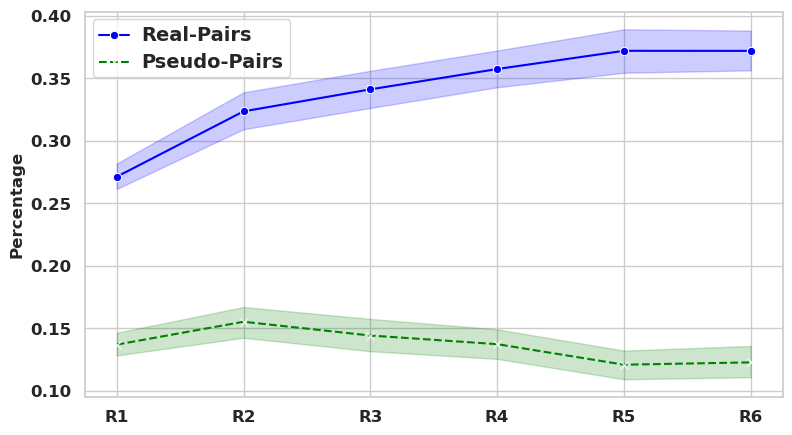

In [23]:
from utils.analysis1 import similarity_of_names_with_utterances, plot_percentage_of_shared_constructions_over_rounds
real_turns_utterances_names = similarity_of_names_with_utterances(real_turns_info, real_speaker_turn_round, pre_post_names, pseudo_or_real='Real', function_words=function_words, stop_words=stop_words, pos_func_words=frequent_words)
pseudo_turns_utterances_names = similarity_of_names_with_utterances(pseudo_turns_info, sudo_speaker_turn_round, pre_post_names, pseudo_or_real='Pseudo', function_words=function_words, stop_words=stop_words, pos_func_words=frequent_words)
plot_percentage_of_shared_constructions_over_rounds(real_turns_utterances_names, pseudo_turns_utterances_names)

## The number of shared constructions per fribble over rounds in dialogues vs. pseudo-dialogues
Participants initially use several shared constructions types per referent and over time some of these constructions tend to be dropped, as common ground is built up. Note that, here we report the number of shared constructions, the reported numbers in the paper are for the number of shared construction types.

<AxesSubplot: xlabel='rounds', ylabel='Number of shared expressions'>

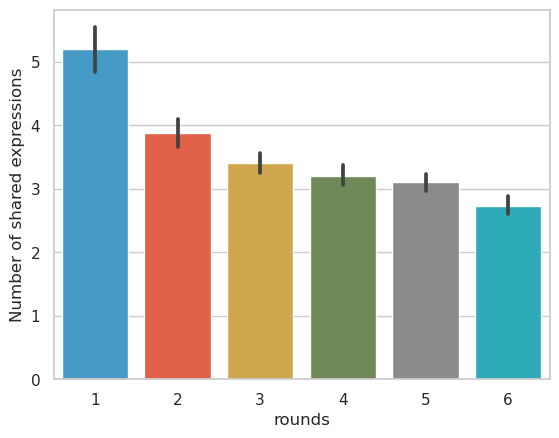

In [24]:
real_speaker_turn_round['rounds']
real_rounds_numbers = real_speaker_turn_round.groupby(['pair', 'rounds', 'target_fribble']).size().reset_index(name='counts')
real_rounds_numbers = real_rounds_numbers.rename(columns={'counts': 'Number of shared expressions'})
real_rounds_numbers['Number of shared expressions'] = real_rounds_numbers['Number of shared expressions'].astype(int)
# plot bar plot the number of shared expressions over rounds
sns.set_theme(style="whitegrid", palette=palette)
sns.barplot(x='rounds', y='Number of shared expressions', data=real_rounds_numbers)


## 3.2. Individual Speaker Names versus Interactive Shared Constructions <a class="anchor" id="individual_vs_shared"></a>

In our second analysis, we investigate the relation between cross-speaker alignment in the interactive task, as captured
by shared constructions, and the names given to the fribbles by each participant in the individual naming task before and after the interaction. This analysis provides key information about what pairs bring to the table before the interaction and whether shared constructions established in interaction are linked to referential labels used after the dialogue.

We start by examining whether the way participants individually name the fribbles is altered after the interactive task. For this, we calculate cosine similarity between the pre- and post-interaction names a participant gave for each fribble. If a speaker used the same name before and after the dialogue, we would obtain a cosine similarity of 1. Instead, we find that the average cosine similarity is 0.27 (std= 0.24), indicating that participants tend to name fribbles differently after the communicative task.

To investigate to what extent this difference is mediated by interaction-based linguistic alignment, we compute the cosine similarity of the dyads’ shared construction types for fribble with the pre-and post-interaction names of each par- ticipant. On average, 41.3% ± 0.09 of pre-interaction names and 61.5% ± 0.10 of post-interaction names per participant overlap with the shared constructions. As shown in Figure below, we find that shared constructions are more similar to post than to pre-interaction names

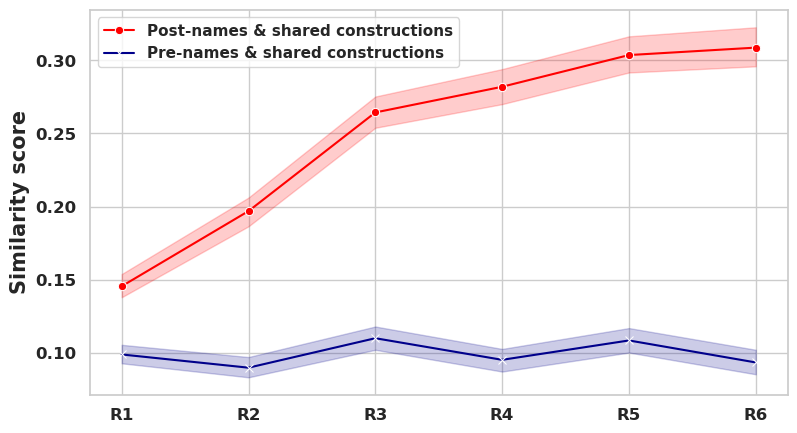

In [25]:
from utils.analysis2 import plot_similarity_of_shared_constructions_to_pre_and_post_names
plot_similarity_of_shared_constructions_to_pre_and_post_names(real_speaker_turn_round, real_turns_utterances_names, pseudo_turns_utterances_names, Pairs='Real')

## 3.3. Naming Convergence Across Speakers is Linked to Shared Constructions <a class="anchor" id="naming_convergence"></a>
Finally, we investigate how similar the names individually given by each speaker to the fribbles before and after the interaction are to each other. Previous studies already showed that the level of cross-speaker name similarity increases after the communicative task. 
Here we ask: To what extent is this converging trend related to the patterns of use of shared constructions?

We first compute the cosine similarity between the two pre-interaction names (Spre) and between the two post-interaction names (Spost ) given by the participants and then measure the difference between these two similarities (Spost − Spre). For actual participant pairs, we find that the mean cosine similarity between the two pre-interaction names is 0.06, while after the interaction, the participant names have a mean cosine similarity of 0.43. Thus, there is an average increase of 0.37 cosine similarity. In contrast, for the pseudo-pairs of participants, the average cosine similarity between the two post-interaction names is -0.07, and the similarity difference between pre-and post-interaction names is 0 in this pseudo-pairs.

Mean for Real: 0.43, std: 0.37
Mean for Pseudo: -0.07, std: 0.20
t-test for Post lemmas similarity: t = nan, p = nan


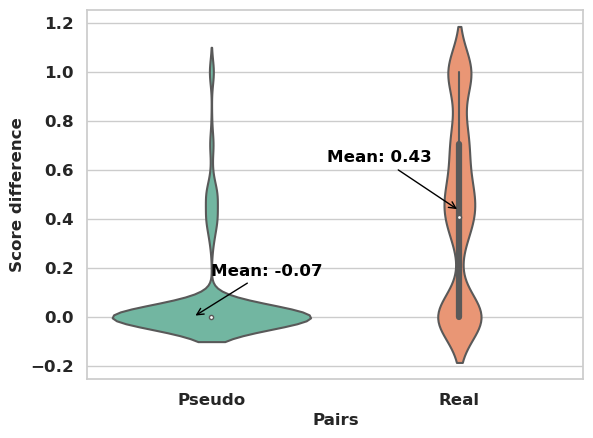

In [26]:
pd.set_option("display.precision", 2)
palette = sns.color_palette(cc.glasbey_hv, n_colors=25)
sns.set_theme(style="whitegrid", palette=palette) 
from utils.gather_naming_similarities import plot_real_vs_pseudo_pairs_scores
plot_real_vs_pseudo_pairs_scores(pre_post_names, 'post_lemmas_lexical_similarity', 'Post lemmas similarity')

## The correlation between the number of shared construction types and the cosine similarity of the post-interaction names

Recall that our first analysis revealed that speakers may not immediately converge on a unique, simple shared construction type. Instead, they may use several complementary descriptions and entertain different alternative views of a referent, as illustrated by the example in Figure 2. We hypothesize that using many different shared construction types may be indicative of difficulty building common ground and finding a simple way to refer to an object, which could lead to less similar post-interaction names. Indeed, we find a weak negative correlation between the number of shared construction types and the cosine similarity of the post-interaction names (Spearman’s ρ = −0.13, p ≪ 0.001): the more construction types for a fribble, the less similar the post-interaction names tend to be, as shown in Figure below:

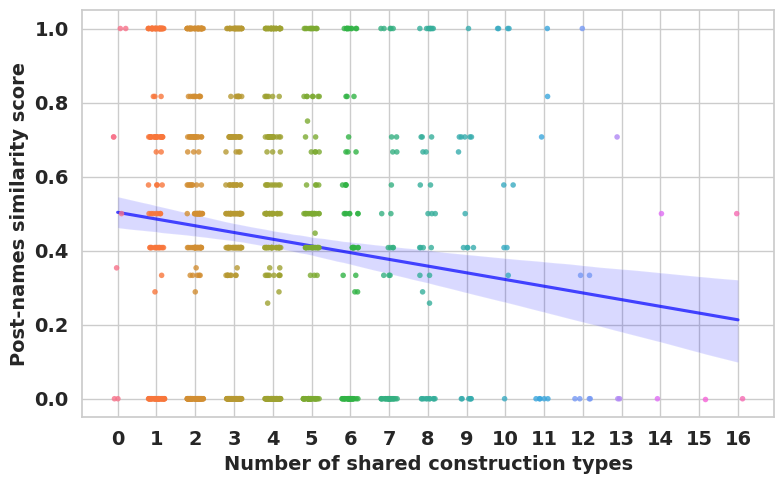

Correlation between Number of shared expression types and post_lemmas_lexical_similarity: -0.13 (p-value: 0.0000)


In [27]:
from utils.analysis3 import plot_number_of_shared_constructions_and_names_similarity
plot_number_of_shared_constructions_and_names_similarity(pre_post_names[pre_post_names['Pairs']=='Real'], 'Number of shared expression types', 'post_lemmas_lexical_similarity')

We also observe a recency and frequency effect as reported in the paper. Please see the figures shown below:

<Figure size 1000x600 with 0 Axes>

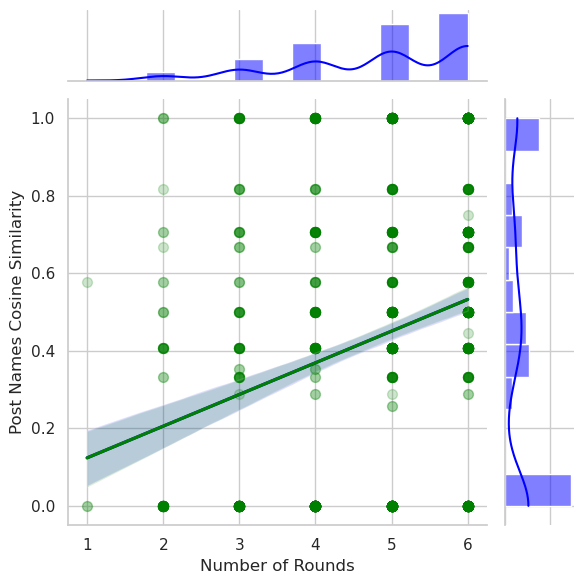

<Figure size 1000x600 with 0 Axes>

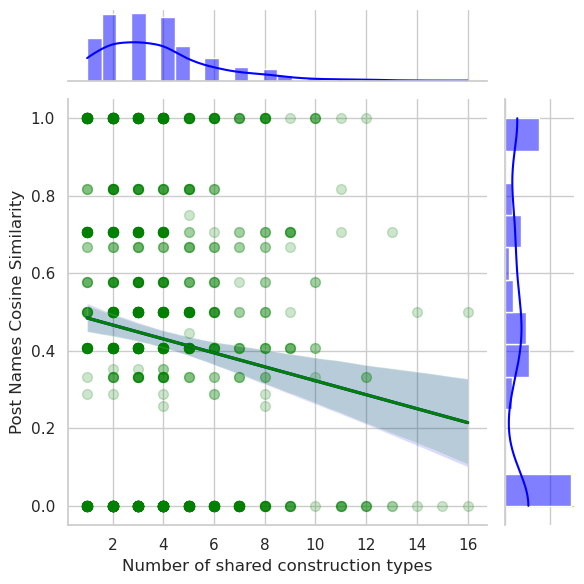

<Figure size 1000x600 with 0 Axes>

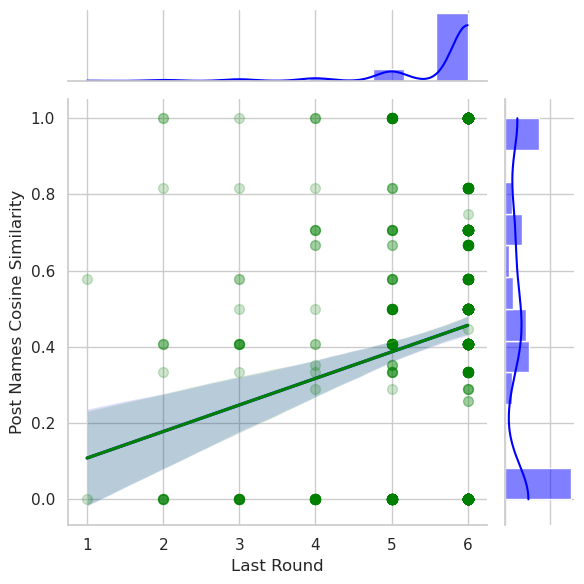

In [30]:
from utils.analysis3 import plot_two_measures_vs_feature

plot_two_measures_vs_feature(pre_post_names, 'Number of Rounds', 'post_lemmas_lexical_similarity', 'Increase in Lemmas Similarity (Cosine Distance)')
pre_post_names.rename(columns={'number of core labels': 'Number of shared expression types'}, inplace=True)

plot_two_measures_vs_feature(pre_post_names, 'Number of shared expression types', 'post_lemmas_lexical_similarity', 'Increase in Lemmas Similarity (Cosine Distance)')
plot_two_measures_vs_feature(pre_post_names, 'Last Round', 'post_lemmas_lexical_similarity', 'Increase in Lemmas Similarity (Cosine Distance)')